*Adapted from https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb*

In [22]:
import tensorflow as tf

Experimentation

In [23]:
z = tf.constant([[1, 2, 3],[4, 5, 6]])
print(z.shape.as_list())

[2, 3]


**Loading the pre-trained model**

In [24]:
x_hat = tf.Variable(tf.zeros((299, 299, 3)))
preprocessed = tf.multiply(tf.subtract(tf.expand_dims(x_hat, 0), 0.5), 2.0)

print(x_hat.get_shape())
print(preprocessed.get_shape())

(299, 299, 3)
(1, 299, 299, 3)


In [25]:
pretrained_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
pretrained_model.trainable = False

In [26]:
logits = pretrained_model(preprocessed)

print(logits.get_shape())

(1, 1000)


In [27]:
random_index = 107  # Jellyfish

labels = tf.one_hot(random_index, logits.shape[-1])
labels = tf.reshape(labels, (1, logits.shape[-1]))
print(labels.get_shape())

(1, 1000)


**Loading and preprocessing an image**

In [28]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)

# Convert into tensor type
image = tf.image.decode_image(image_raw)

print(image.get_shape())

(577, 700, 3)


In [29]:
# Preprocessing for InceptionV3
def preprocess (image):
  input = tf.cast(image, tf.float32)
  input = tf.image.resize(input, (299, 299))
  
  # Return pixel values scaled between -1 and 1, sample-wise
  # i.e. RGB value is scaled from [0, 255] to [-1, 1]
  input = tf.keras.applications.inception_v3.preprocess_input(input)

  # Shape = (299, 299, 3)

  # '...' is a placeholder for not yet written code, i.e. '...' = 299, ,299, 3
  # To be able to be pointed by imshow
  input = input[None, ...]

  # Shape = (1, 299, 299, 3)

  return input


**Create a function `classify` to show image and model's prediction**

In [30]:
import matplotlib.pyplot as plt

In [31]:
def classify(img):
  plt.figure
 
  plt.imshow(img[0]*0.5+0.5)  # To change [-1, 1] to [0,1]
  prediction = pretrained_model.predict(img)

  top = 5
  prediction_decoded = tf.keras.applications.inception_v3.decode_predictions(prediction, top=top)
  for i in range(top):
    print("Class: " + prediction_decoded[0][i][1] + 
          "; Confidence: " + str(round(prediction_decoded[0][i][2]*100, 2)) + "%")

Class: Labrador_retriever; Confidence: 29.54%
Class: bull_mastiff; Confidence: 3.68%
Class: Eskimo_dog; Confidence: 3.03%
Class: Chesapeake_Bay_retriever; Confidence: 2.56%
Class: dingo; Confidence: 2.07%


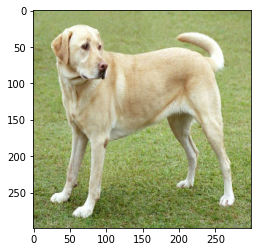

In [32]:
x = preprocess(image)
classify(x)

**Generating Adversarial Examples using FGSM**


In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [34]:
def create_adversarial_pattern_modified(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  return gradient

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


(1, 299, 299, 3)


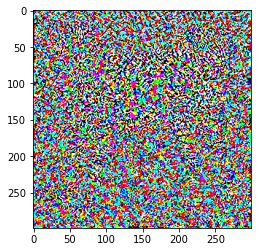

In [35]:
perturbations = create_adversarial_pattern(x, labels)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

print(perturbations.get_shape())

In [36]:
# Pertubation from pure gradient (instead of signed gradient)
pertubations_modified = create_adversarial_pattern_modified(x, labels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: Great_Dane; Confidence: 4.6%
Class: Rhodesian_ridgeback; Confidence: 3.69%
Class: bull_mastiff; Confidence: 3.1%
Class: dingo; Confidence: 1.75%
Class: Ibizan_hound; Confidence: 1.51%


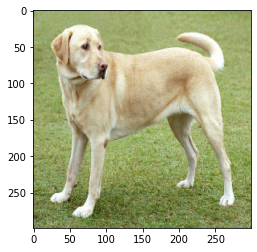

In [37]:
eps = 0.01

# Note that because a random class is used to generate the pertubation,
# a minus sign is used instead of plus compared to that of a FGSM
adv_x = x - eps*perturbations

# x is a preprocessed data with RBG range [-1, 1], 
# however adv_x is not, therefor the clipping error in matplotlib.pyplot.imshow(), insignificant
classify(adv_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: Great_Dane; Confidence: 9.92%
Class: bloodhound; Confidence: 2.78%
Class: bull_mastiff; Confidence: 2.13%
Class: dingo; Confidence: 1.36%
Class: Ibizan_hound; Confidence: 1.17%


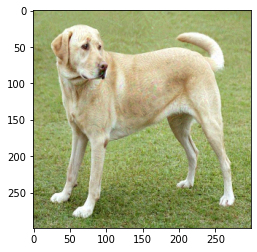

In [49]:
eps_modified = 3

# Note that because a random class is used to generate the pertubation,
# a minus sign is used instead of plus compared to that of a FGSM
adv_x_modified = x - eps_modified*pertubations_modified

# x is a preprocessed data with RBG range [-1, 1], 
# however adv_x is not, therefor the clipping error in matplotlib.pyplot.imshow(), insignificant
classify(adv_x_modified)